#1 Loading data, libraries and functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted

from __future__ import print_function
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.python.client import device_lib

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from tensorflow.keras.utils import plot_model

In [ ]:
# Linking GoogleDrive + accessing data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
# Verify if subfolders are in TRAIN root folder, 0=Organic, 1=Recyclable, 2=Non Recyclable
DATASET_PATH_TRAIN='gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
for classes in os.listdir(DATASET_PATH_TRAIN):
  d=os.path.join(DATASET_PATH_TRAIN, classes)
  if os.path.isdir(d):
    print(d)

gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank/2 - Moderate Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank/3 - Lot Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank/0 - No Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank/1 - Little Plastic


In [ ]:
# Verify if subfolders are in TEST root folder, 0=Organic, 1=Recyclable, 2=Non Recyclable
DATASET_PATH_TEST='gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank'
for classes in os.listdir(DATASET_PATH_TEST):
  d=os.path.join(DATASET_PATH_TEST, classes)
  if os.path.isdir(d):
    print(d)

gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/0 - No Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/1 - Little Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/2 - Moderate Plastic
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/3 - Lot Plastic


In [ ]:
pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn

  Cloning https://github.com/datumbox/keras (to revision bugfix/trainable_bn) to /tmp/pip-req-build-mcgvrukd
  Running command git clone -q https://github.com/datumbox/keras /tmp/pip-req-build-mcgvrukd
  Running command git checkout -b bugfix/trainable_bn --track origin/bugfix/trainable_bn
  Switched to a new branch 'bugfix/trainable_bn'
  Branch 'bugfix/trainable_bn' set up to track remote branch 'bugfix/trainable_bn' from 'origin'.
  Created wheel for Keras: filename=Keras-2.2.4-cp37-none-any.whl size=311046 sha256=47ef46f0db9a681053cbc36d1592e32f18e5cc7e92f3a15fbaad9e0345f30c47
  Stored in directory: /tmp/pip-ephem-wheel-cache-ze8i2v1y/wheels/36/5d/50/99c268bf64c1394c4f5b743164e4e515ab30290a523595ac47
Successfully built Keras
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


#2 Preprocessing data

In [ ]:
# Defining image height and width
image_height=224
image_width=224
batch_size=32

In [ ]:
path_train = 'gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
path_val = 'gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank'

In [ ]:
def import_dataset(path_train, path_val, image_height, image_width, batch_size):
  # Creating a training dataset
  ds_train = tf.keras.preprocessing.image_dataset_from_directory(
      path_train,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=(image_height,image_width),
      batch_size=batch_size,
      shuffle=True,
      seed=123,
      interpolation='bilinear'
)
  # Creating a validation dataset
  ds_val = tf.keras.preprocessing.image_dataset_from_directory(
      path_val,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=(image_height,image_width),
      batch_size=batch_size,
      shuffle=True,
      seed=123,
      validation_split=val_split,
      subset='validation',
      interpolation='bilinear'
) 
  
  return ds_train, ds_val

In [ ]:
ds_train, ds_val=import_dataset(path_train, path_val, image_height, image_width, batch_size)

FileNotFoundError: ignored

In [ ]:
def plot_results_loss(r, training_title, label_name_loss, label_name_val_loss, colors):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()

  plt.figure(figsize=(15,8))

  for key,c in zip(r, colors):
    plt.plot(r[key].history['loss'], label= f'{label_name_loss}: {key}', color=c)
    plt.plot(r[key].history['val_loss'], label=f'{label_name_val_loss}: {key}', ls= '--', color=c)
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss [-]')
  plt.title(training_title, fontsize=16, fontweight= 'bold')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
def plot_results_acc(r, training_title, label_name_acc, label_name_val_acc, colors):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()

  plt.figure(figsize=(15,8))

  for key,c in zip(r, colors):
    plt.plot(r[key].history['accuracy'], label= f'{label_name_acc}: {key}', color=c)
    plt.plot(r[key].history['val_accuracy'], label=f'{label_name_val_acc}: {key}', ls= '--', color=c)
  
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy [-]')
  plt.title(training_title, fontsize=16, fontweight= 'bold')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=20, fontweight='bold')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

#3 Increase of data performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

#4 Addressing Class Imbalance

In [ ]:
path = 'gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
folders = os.listdir('gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank') # dir is your directory path
num = []

for folder in folders:
    dir = path + '/' + str(folder)
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    num.append(len(onlyfiles))

total_img=np.sum(num)

In [ ]:
num_classes=4
class_weight_train = {0: (total_img/num[3])/num_classes,
                1: (total_img/num[0])/num_classes,
                2: (total_img/num[2])/num_classes,
                3: (total_img/num[1])/num_classes}

In [ ]:
class_weight_train

{0: 1.5767716535433072,
 1: 1.0640276301806588,
 2: 0.7362132352941176,
 3: 0.936623012160898}

#5 Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121

In [ ]:
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16980009637381361341, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13149895912429912507
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## 5.1 MobileNet V2


In [ ]:
mobile_model=MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_model.trainable=True

print('Number of layers in the MobileNetV2 model: ', len(mobile_model.layers))

Number of layers in the MobileNetV2 model:  154


In [ ]:
mobile_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#from tensorflow.keras.utils import plot_model
plot_model(mobile_model, show_shapes=True)

In [ ]:
num_classes=4
model_MobileV2 = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  mobile_model, 
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_MobileV2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_22 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_22  (None, 1280)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_50 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)             

In [ ]:
model_MobileV2.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_mobilenet_scratch.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)  

# list together
callbacks = [mcp_save] 

epochs=30
r_mobileV2 = model_MobileV2.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

Epoch 1/30
126/126 [==============================] - 104s 766ms/step - loss: 1.0407 - accuracy: 0.4964 - val_loss: 1.6870 - val_accuracy: 0.5730
Epoch 2/30
126/126 [==============================] - 97s 736ms/step - loss: 0.5280 - accuracy: 0.7630 - val_loss: 8.4197 - val_accuracy: 0.2647
Epoch 3/30
126/126 [==============================] - 89s 680ms/step - loss: 0.5061 - accuracy: 0.7680 - val_loss: 5.8660 - val_accuracy: 0.4257
Epoch 4/30
126/126 [==============================] - 88s 674ms/step - loss: 0.3743 - accuracy: 0.8267 - val_loss: 8.0547 - val_accuracy: 0.3833
Epoch 5/30
126/126 [==============================] - 88s 675ms/step - loss: 0.4097 - accuracy: 0.8006 - val_loss: 8.8642 - val_accuracy: 0.1923
Epoch 6/30


KeyboardInterrupt: ignored

##5.2 ResNet50

In [ ]:
ResNet50_model=ResNet50(input_shape=(224, 224, 3), include_top=False)
ResNet50_model.trainable=True
print('Number of layers in the MobileNetV2 model: ', len(ResNet50_model.layers))

Number of layers in the MobileNetV2 model:  175


In [ ]:
ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
num_classes=4
model_ResNet50 = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  ResNet50_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_ResNet50.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_ResNet50.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_34 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_34  (None, 2048)              0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_84 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)             

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_ResNet50_scratch.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)  

# list together
callbacks = [mcp_save] 

epochs=30
r_ResNet50 = model_ResNet50.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

Epoch 1/30
126/126 [==============================] - 28s 183ms/step - loss: 1.2438 - accuracy: 0.3894 - val_loss: 1.5509 - val_accuracy: 0.2347
Epoch 2/30
126/126 [==============================] - 22s 176ms/step - loss: 0.5758 - accuracy: 0.7282 - val_loss: 1.5843 - val_accuracy: 0.2672
Epoch 3/30
126/126 [==============================] - 22s 176ms/step - loss: 0.3368 - accuracy: 0.8403 - val_loss: 2.3075 - val_accuracy: 0.1935
Epoch 4/30
126/126 [==============================] - 22s 176ms/step - loss: 0.2408 - accuracy: 0.8910 - val_loss: 2.6495 - val_accuracy: 0.2772
Epoch 5/30
126/126 [==============================] - 22s 176ms/step - loss: 0.1177 - accuracy: 0.9566 - val_loss: 4.7046 - val_accuracy: 0.2484
Epoch 6/30
126/126 [==============================] - 22s 176ms/step - loss: 0.1030 - accuracy: 0.9553 - val_loss: 3.3100 - val_accuracy: 0.3296
Epoch 7/30
126/126 [==============================] - 22s 176ms/step - loss: 0.0847 - accuracy: 0.9666 - val_loss: 2.6740 - val_ac

##5.3 InceptionV3

In [ ]:
InceptionV3_model=InceptionV3(input_shape=(224, 224, 3), include_top=False)
InceptionV3_model.trainable=True

print('Number of layers in the InceptionV3 model: ', len(InceptionV3_model.layers))

Number of layers in the InceptionV3 model:  311


In [ ]:
InceptionV3_model.summary()

In [ ]:
num_classes=4
model_InceptionV3 = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  InceptionV3_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_InceptionV3.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_33 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_33  (None, 2048)              0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)             

In [ ]:
model_InceptionV3.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_inceptionv3_scratch.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)  

# list together
callbacks = [mcp_save] 

epochs=30
r_InceptionV3 = model_InceptionV3.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

Epoch 1/30
126/126 [==============================] - 26s 159ms/step - loss: 1.2571 - accuracy: 0.3741 - val_loss: 1.2345 - val_accuracy: 0.4220
Epoch 2/30
126/126 [==============================] - 19s 150ms/step - loss: 0.6389 - accuracy: 0.6811 - val_loss: 1.0647 - val_accuracy: 0.5868
Epoch 3/30
126/126 [==============================] - 19s 151ms/step - loss: 0.3529 - accuracy: 0.8464 - val_loss: 0.9599 - val_accuracy: 0.6542
Epoch 4/30
126/126 [==============================] - 19s 150ms/step - loss: 0.2064 - accuracy: 0.9131 - val_loss: 0.9722 - val_accuracy: 0.7004
Epoch 5/30
126/126 [==============================] - 19s 150ms/step - loss: 0.1510 - accuracy: 0.9392 - val_loss: 1.1009 - val_accuracy: 0.7241
Epoch 6/30
126/126 [==============================] - 19s 150ms/step - loss: 0.0807 - accuracy: 0.9713 - val_loss: 1.0711 - val_accuracy: 0.6941
Epoch 7/30
126/126 [==============================] - 19s 150ms/step - loss: 0.0766 - accuracy: 0.9682 - val_loss: 1.1539 - val_ac

##5.4 DenseNet121

In [ ]:
DenseNet121_model=DenseNet121(input_shape=(224, 224, 3), include_top=False)
DenseNet121_model.trainable=True

print('Number of layers in the MobileNetV2 model: ', len(DenseNet121_model.layers))

29089792/29084464 [==============================] - 0s 0us/step
Number of layers in the MobileNetV2 model:  427


In [ ]:
DenseNet121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_25[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
DenseNet121_model=DenseNet121(input_shape=(224, 224, 3), include_top=False)
num_classes=4
model_DenseNet121 = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  DenseNet121_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_DenseNet121.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_denseNet_scratch.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)

#list together
callbacks = [mcp_save] 

epochs=30
r_DenseNet121 = model_DenseNet121.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

Epoch 1/30
185/185 [==============================] - 3128s 2s/step - loss: 1.3233 - accuracy: 0.3840 - val_loss: 0.9885 - val_accuracy: 0.5356
Epoch 2/30
185/185 [==============================] - 67s 363ms/step - loss: 0.5454 - accuracy: 0.7454 - val_loss: 0.5174 - val_accuracy: 0.8065
Epoch 3/30
185/185 [==============================] - 67s 361ms/step - loss: 0.3202 - accuracy: 0.8559 - val_loss: 0.4283 - val_accuracy: 0.8165
Epoch 4/30
185/185 [==============================] - 67s 361ms/step - loss: 0.2137 - accuracy: 0.9011 - val_loss: 0.4639 - val_accuracy: 0.8377
Epoch 5/30
185/185 [==============================] - 67s 361ms/step - loss: 0.1400 - accuracy: 0.9467 - val_loss: 0.6690 - val_accuracy: 0.7803
Epoch 6/30
185/185 [==============================] - 67s 360ms/step - loss: 0.1108 - accuracy: 0.9543 - val_loss: 0.8208 - val_accuracy: 0.7640
Epoch 7/30
185/185 [==============================] - 67s 360ms/step - loss: 0.0748 - accuracy: 0.9705 - val_loss: 1.3427 - val_acc

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from __future__ import print_function
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPool2D, Lambda, BatchNormalization, Concatenate, AvgPool2D
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow import keras

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib

In [ ]:
  num_classes = 4

  i = Input(shape=(image_height, image_width, 3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(i, x)

In [ ]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_27m.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)

callbacks = [mcp_save] 

epochs=30
r = model.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

Epoch 1/30
126/126 [==============================] - 1454s 11s/step - loss: 1.2343 - accuracy: 0.4027 - val_loss: 0.9521 - val_accuracy: 0.5368
Epoch 2/30
126/126 [==============================] - 73s 558ms/step - loss: 0.8796 - accuracy: 0.5764 - val_loss: 0.7791 - val_accuracy: 0.6742
Epoch 3/30
126/126 [==============================] - 73s 556ms/step - loss: 0.7490 - accuracy: 0.6331 - val_loss: 0.7051 - val_accuracy: 0.7116
Epoch 4/30
126/126 [==============================] - 73s 551ms/step - loss: 0.6673 - accuracy: 0.6904 - val_loss: 0.7098 - val_accuracy: 0.6617
Epoch 5/30
126/126 [==============================] - 73s 552ms/step - loss: 0.6239 - accuracy: 0.7097 - val_loss: 0.6412 - val_accuracy: 0.7378
Epoch 6/30
126/126 [==============================] - 73s 553ms/step - loss: 0.5808 - accuracy: 0.7195 - val_loss: 0.6645 - val_accuracy: 0.6929
Epoch 7/30
126/126 [==============================] - 73s 553ms/step - loss: 0.5436 - accuracy: 0.7459 - val_loss: 0.6969 - val_ac

##5.5 Squeeze Net

SqueezNet is not in the Keras applications (as compared to the other models), therefore the model was implemented manually. Therefore https://github.com/rcmalli/keras-squeezenet was used with slight modifications. The structure as proposed by Iandola et al., 2017 was used, whereby the top was added according to the need of the examined dataset.

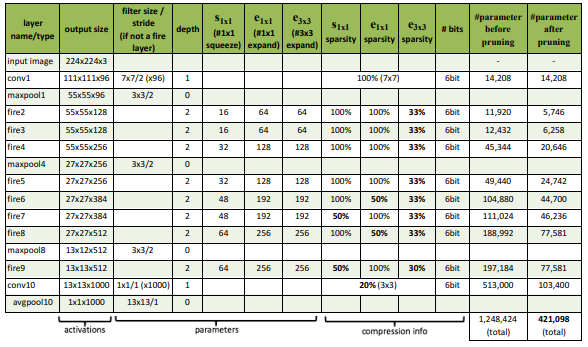

In [ ]:
pip install keras_applications

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

    return model


In [ ]:
SqueezeNet_model = SqueezeNet(input_shape=(224, 224, 3), include_top=False)
SqueezeNet_model.trainable=True

print('Number of layers in the SqueezeNet model: ', len(SqueezeNet_model.layers))

Number of layers in the SqueezeNet model:  62


In [ ]:
image_height=224
image_width=224
num_classes=4
model_SqueezeNet = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  SqueezeNet_model,
  keras.layers.Conv2D(1000, (1, 1), strides=1, padding='valid', name='conv10'),
  keras.layers.BatchNormalization(momentum=0.6),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_SqueezeNet.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_30 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
squeezenet (Functional)      (None, 13, 13, 512)       722496    
_________________________________________________________________
conv10 (Conv2D)              (None, 13, 13, 1000)      513000    
_________________________________________________________________
global_average_pooling2d_30  (None, 1000)              0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_74 (Dense)             (None, 256)             

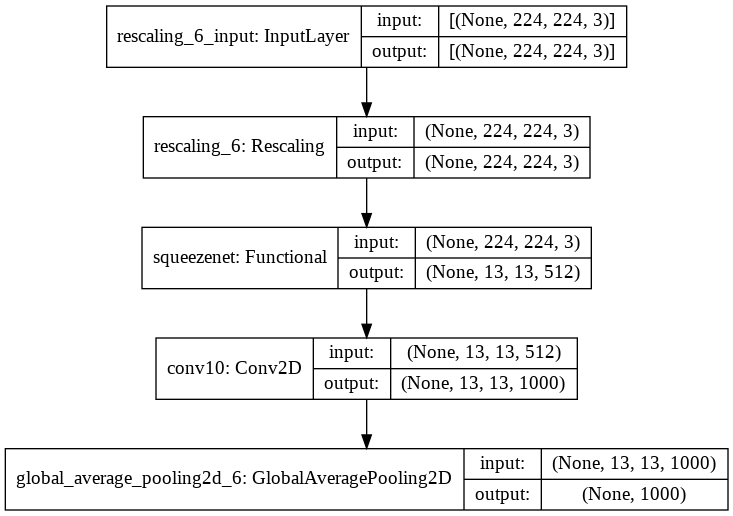

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_SqueezeNet, show_shapes=True)

In [ ]:
model_SqueezeNet.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts_squeezeNet_scratch.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True) 

# list together
callbacks=[mcp_save]

epochs=30
r_SqueezeNet = model_SqueezeNet.fit(
    ds_train, 
    validation_data=ds_val, 
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_train)

#6 Visualization of transfer learning model results

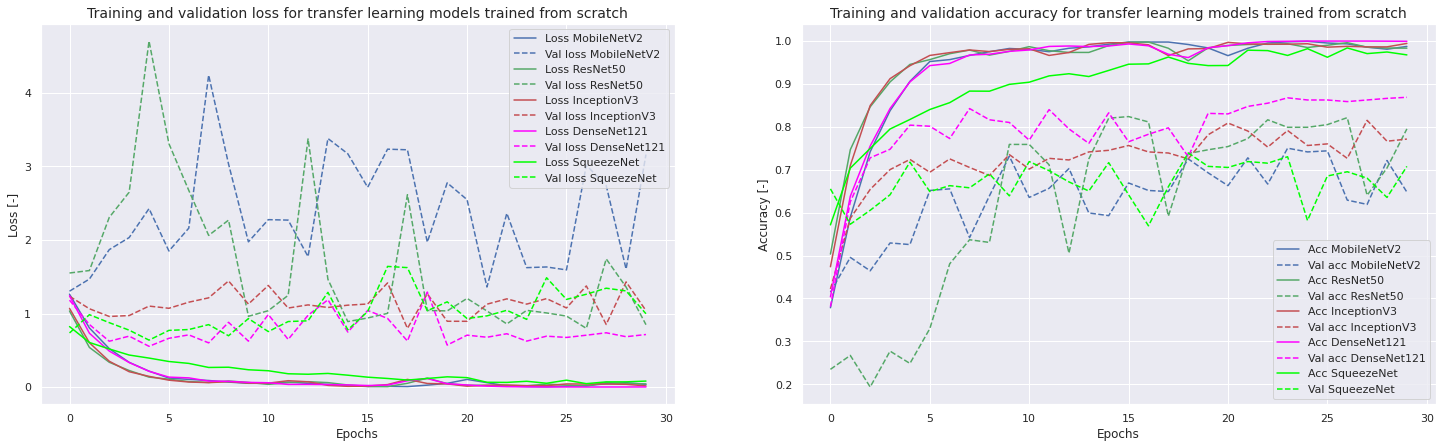

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

f, ax = plt.subplots(1,2,figsize=(25,7))
ax[0].plot(r_mobileV2.history['loss'], label = 'Loss MobileNetV2', color = 'b')
ax[0].plot(r_mobileV2.history['val_loss'], label = 'Val loss MobileNetV2', color = 'b', ls= '--')
ax[0].plot(r_ResNet50.history['loss'], label = 'Loss ResNet50', color = 'g')
ax[0].plot(r_ResNet50.history['val_loss'], label = 'Val loss ResNet50', color = 'g', ls= '--')
ax[0].plot(r_InceptionV3.history['loss'], label = 'Loss InceptionV3', color = 'r')
ax[0].plot(r_InceptionV3.history['val_loss'], label = 'Val loss InceptionV3', color = 'r', ls= '--')
ax[0].plot(r_DenseNet121.history['loss'], label = 'Loss DenseNet121', color = 'magenta')
ax[0].plot(r_DenseNet121.history['val_loss'], label = 'Val loss DenseNet121', color = 'magenta', ls= '--')
ax[0].plot(r_SqueezeNet.history['loss'], label = 'Loss SqueezeNet', color = 'lime')
ax[0].plot(r_SqueezeNet.history['val_loss'], label = 'Val loss SqueezeNet', color = 'lime', ls= '--')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss [-]')
ax[0].set_title('Training and validation loss for transfer learning models trained from scratch', fontsize=14)
ax[0].legend()
ax[1].plot(r_mobileV2.history['accuracy'], label = 'Acc MobileNetV2', color = 'b')
ax[1].plot(r_mobileV2.history['val_accuracy'], label = 'Val acc MobileNetV2', color = 'b', ls= '--')
ax[1].plot(r_ResNet50.history['accuracy'], label = 'Acc ResNet50', color = 'g')
ax[1].plot(r_ResNet50.history['val_accuracy'], label = 'Val acc ResNet50', color = 'g', ls= '--')
ax[1].plot(r_InceptionV3.history['accuracy'], label = 'Acc InceptionV3', color = 'r')
ax[1].plot(r_InceptionV3.history['val_accuracy'], label = 'Val acc InceptionV3', color = 'r', ls= '--')
ax[1].plot(r_DenseNet121.history['accuracy'], label = 'Acc DenseNet121', color = 'magenta')
ax[1].plot(r_DenseNet121.history['val_accuracy'], label = 'Val acc DenseNet121', color = 'magenta', ls= '--')
ax[1].plot(r_SqueezeNet.history['accuracy'], label = 'Acc SqueezeNet', color = 'lime')
ax[1].plot(r_SqueezeNet.history['val_accuracy'], label = 'Val SqueezeNet', color = 'lime', ls= '--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy [-]')
ax[1].set_title('Training and validation accuracy for transfer learning models trained from scratch', fontsize=14)
ax[1].legend();

In [ ]:

val_acc = round(np.max(r_mobileV2.history['val_accuracy'])*100, 2)
val_loss = round(np.min(r_mobileV2.history['val_loss']), 2)
print(f'The best validation accuracy of MobileNetV2 is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of MobileNetV2 is 75.03% and validation loss is 1.3


In [ ]:
val_acc = round(np.max(r_ResNet50.history['val_accuracy'])*100, 2)
val_loss = round(np.min(r_ResNet50.history['val_loss']), 2)
print(f'The best validation accuracy of ResNet50 is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of ResNet50 is 82.4% and validation loss is 0.8


In [ ]:
val_acc = round(np.max(r_InceptionV3.history['val_accuracy'])*100, 2)
val_loss = round(np.min(r_InceptionV3.history['val_loss']), 2)
print(f'The best validation accuracy of InceptionV3 is {val_acc}% and validation loss is {val_loss}')

In [ ]:
val_acc = round(np.max(r_DenseNet121.history['val_accuracy'])*100, 2)
val_loss = round(np.min(r_DenseNet121.history['val_loss']), 2)
print(f'The best validation accuracy of DenseNet is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of DenseNet is 86.89% and validation loss is 0.41


In [ ]:
val_acc = round(np.max(r_DenseNet121.history['val_accuracy'])*100, 2)
val_loss = round(np.min(r_DenseNet121.history['val_loss']), 2)
print(f'The best validation accuracy of SqueezeNet is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of SqueezeNet is 86.89% and validation loss is 0.55


#7 Confusion matrix

In [ ]:
y_true = np.concatenate([y for x, y in ds_val], axis=0)
x_val = np.concatenate([x for x, y in ds_val], axis=0)
y_pred = model.predict(ds_val).argmax(axis=1)
plt.figure(figsize=(8,8))
plt.grid(False)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, list(range(num_classes)))